In [1]:
import numpy as np
from pytrr import GroTrrReader
import pandas as pd
from sklearn import utils
from tqdm import trange
import matplotlib.pyplot as plt
import statistics

In [2]:
energy_path = 'energy.xvg'
trr_path = 'traj.trr'

In [83]:
def get_energy_colvar(colvar, frames):
    with open('../WTE_1/COLVAR', 'r') as c:
        c = c.readlines()
    c = [l.rstrip('\n') for l in c]
    energy = []
    for e in c[1:frames+1]:
    #     print(e.split())
        energy.append(e.split()[1])
    energy = [float(e)*0.239006 for e in energy] #kj/mol to kcal/mol
    energy = np.array(energy)
#     print(energy)
    return energy

In [3]:
def get_energy_xvg(xvg, frames):
    with open(xvg,'r') as e:
        e = e.readlines()
    e = [l.rstrip('\n') for l in e]
    del e[:2000]
#     del e[:23]

#     idx = len(e) - 1     #make idx file
#     idx = np.arange(idx)
#     np.random.shuffle(idx)
#     np.savetxt('idx.txt', idx)

    idx = np.loadtxt('idx.txt') #load idx file
    idx = idx.astype(int)
    e = np.array(e)
    e = e[idx]   #shuffle
    energy = []
    for c in e[1:frames+1]:
        energy.append(c.split()[1])
    energy = [float(e)*0.239006 for e in energy] #kj/mol to kcal/mol
    energy = np.array(energy)
    print(energy.shape)
    return energy

In [16]:
def get_distribution(energy, traj, n_samples, discard, nmols, npzfile):
    """
    inputs: energy_file, trr_file, 
            n_samples: no. of frames for the output file, 
            discard: number of frames to discard from the input file
            nmols: number of molecules in the system
            npzfile: file output name
    """
    ener_og = np.loadtxt(energy)
    ener_og = ener_og[discard:]
    print('ener_og shape', ener_og.shape)
    
    (n, bins, patches) = plt.hist(ener_og[:,1], bins=50) #default bins = 50
#     m = statistics.mean(ener_og[:,1])
#     plt.axvline(m, color='black')

#     sd = statistics.stdev(ener_og[:,1])

#     plt.axvline(m + sd, color='red')
#     plt.axvline(m - sd, color='red')

#     plt.axvline(m + 2*sd, color='red')
#     plt.axvline(m - 2*sd, color='red')

#     plt.show()
    bin_id = []
    for ener in range(len(ener_og[:,1])):
        for b in range(len(bins)):

            if ener_og[:,1][ener] <= bins[b]:
                bin_id.append((ener_og[:,1][ener],b))
                break
    tmp = np.array(bin_id)
    tmp_dict = {}
    for i in range(len(tmp)):
        if int(tmp[i][1]) in tmp_dict:
            tmp_dict[int(tmp[i][1])].append(i)
        else:
            tmp_dict[int(tmp[i][1])] = [i]
            
    sampled_bins = np.random.choice(np.arange(len(bins)), size=n_samples+100, replace=True)
    sampled_frames = []
    counter = 0
    while len(sampled_frames) < n_samples:
        bin_idx = sampled_bins[counter]
        try:
            frame_idxs = tmp_dict[bin_idx]
            sel_frame_idx = np.random.choice(frame_idxs, size=1, replace=False)[0]
            sampled_frames.append(sel_frame_idx)
        except:
            pass
        counter += 1
    plt.hist(ener_og[sampled_frames,1])
    plt.show()
    
    np.savetxt('sampled_frames.txt', sampled_frames)
    
    energy = ener_og[sampled_frames,1]
    energy = np.multiply(energy,0.239006) #kj/mol to kcal/mol
    print('energy_final shape', energy.shape)
    
    fxyz = []
    xyz = []
    with GroTrrReader(traj) as trrfile:
        for frame in trrfile:
            frame_data = trrfile.get_data()
            fxyz.append(frame_data['f'])
            xyz.append(frame_data['x'])
            
    fxyz = fxyz[discard:]
    xyz = xyz[discard:]
    
    fxyz = np.array(fxyz)
    xyz = np.array(xyz)
    
    fxyz = fxyz[sampled_frames]
    xyz = xyz[sampled_frames]
    
    fxyz = np.multiply(fxyz, 0.0239006) #kj/mol/nm to kcal/mol/A
    xyz = np.multiply(xyz,10) #nm to A
    print('fxyz_shape', fxyz.shape)
    print('xyz shape', xyz.shape)
    w_name = np.array(b'water_trr_xyz')
    w_theory = np.array(b'')
    w_type = np.array(b'd')
    w_z = np.array([8,1,1]*nmols, dtype='uint8')
    np.savez(npzfile, E=energy, R=xyz, F=fxyz, theory=w_theory, type=w_type, z=w_z)

ener_og shape (8000, 2)


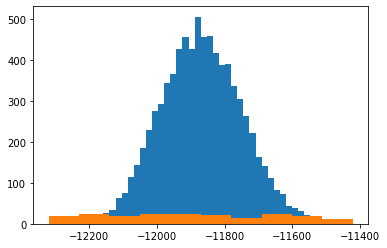

energy_final shape (200,)
fxyz_shape (200, 750, 3)
xyz shape (200, 750, 3)


In [17]:
get_distribution('energy.xvg', 'traj.trr', 200, 2001, 250, 'test.npz')

In [19]:
file = np.load('test.npz')

In [21]:
file.files

['E', 'R', 'F', 'theory', 'type', 'z']

In [4]:
def make_npz(traj, xvg, frames, npzfile, nmols):
    fxyz = []
    xyz = []
    with GroTrrReader(traj) as trrfile:
        for frame in trrfile:
            frame_data = trrfile.get_data()
            fxyz.append(frame_data['f'])
            xyz.append(frame_data['x'])
#             if len(xyz) > frames-1:
#                 break
    #removing 1ns frames
    del fxyz[:2000]
    del xyz[:2000]
    
    fxyz = np.array(fxyz)
    xyz = np.array(xyz)
    
    
    #shuffling
    idx = np.loadtxt('idx.txt')
    idx = idx.astype(int)
    fxyz = fxyz[idx]
    xyz = xyz[idx]
    
    
    fxyz = fxyz[:frames]
    xyz = xyz[:frames]
    
    fxyz = np.multiply(fxyz,0.0239006) #kj/mol/nm to kcal/mol/A
    xyz = np.multiply(xyz,10) #nm to A
    
    energy = get_energy_xvg(xvg, frames)
    w_name = np.array(b'water_trr_xyz')
    w_theory = np.array(b'')
    w_type = np.array(b'd')
    w_z = np.array([8,1,1]*nmols, dtype='uint8')
    np.savez(npzfile, E=energy, R=xyz, F=fxyz, theory=w_theory, type=w_type, z=w_z)

In [17]:
make_npz(trr_path, energy_path, 200, 'water250_nvt_200.npz', 250)

(200,)


In [3]:
file = np.load('water250_nvt_200.npz')

In [4]:
file.files

['E', 'R', 'F', 'theory', 'type', 'z']

In [20]:
file['F'].shape

(200, 750, 3)

In [21]:
file['R'].shape

(200, 750, 3)

In [22]:
file['E'].shape

(200,)

## sampling code below

In [428]:
ener_og = np.loadtxt('energy.xvg')

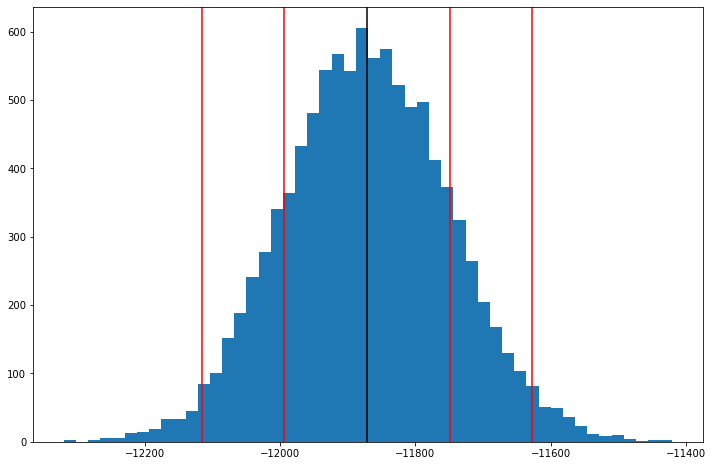

In [418]:
plt.figure(figsize=(12,8))
(n, bins, patches) = plt.hist(ener_og[:,1], bins=50)

m = statistics.mean(ener_og[:,1])
plt.axvline(m, color='black')

sd = statistics.stdev(ener_og[:,1])

plt.axvline(m + sd, color='red')
plt.axvline(m - sd, color='red')

plt.axvline(m + 2*sd, color='red')
plt.axvline(m - 2*sd, color='red')

plt.show()

In [419]:
bin_id = []
for ener in range(len(ener_og[:,1])):
    for b in range(len(bins)):
#         if b < 50:
#             if (ener_og[:,1][ener] > bins[b]) and (ener_og[:,1][ener] < bins[b+1]):
        if ener_og[:,1][ener] <= bins[b]:
            bin_id.append((ener_og[:,1][ener],b))
            break

In [420]:
tmp = np.array(bin_id)

In [421]:
tmp_dict = {}
for i in range(len(tmp)):
    if int(tmp[i][1]) in tmp_dict:
        tmp_dict[int(tmp[i][1])].append(i)
    else:
        tmp_dict[int(tmp[i][1])] = [i]

# tmp_dict = OrderedDict(sorted(tmp_dict.items()))

ener_og shape (8000, 2)


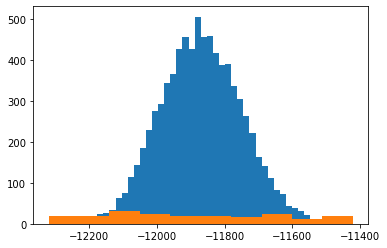

In [8]:
get_distribution('energy.xvg', 200, 2001)

In [5]:
n_samples = 200
sampled_bins = np.random.choice(np.arange(len(bins)), size=n_samples+100, replace=True)
sampled_frames = []
counter = 0
while len(sampled_frames) < n_samples:
    bin_idx = sampled_bins[counter]
    try:
        frame_idxs = tmp_dict[bin_idx]
        sel_frame_idx = np.random.choice(frame_idxs, size=1, replace=False)[0]
        sampled_frames.append(sel_frame_idx)
    except:
        pass
    counter += 1
    

NameError: name 'bins' is not defined

In [440]:
ener_og[sampled_frames,1].shape

(200,)

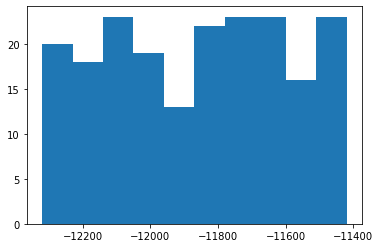

In [425]:
plt.hist(ener_og[sampled_frames,1])
plt.show()

In [379]:
len(sampled_frames)

200